In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Al 
from meep.materials import Al2O3  

In [2]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 100             # 추출할 주파수 개수
design_region_resolution = 50

In [3]:
tal = 1
talq3 = 0.5
tsio2 = 2

tair_near = 3.5
tair_far = 6

tpml = 0.5

tmetal_boundary = 1


design_region_width = 5       # OLED의 가로/세로 길이
design_region_height = 1
metal_boundary_height = tal+talq3+design_region_height+tsio2

al = Al

metal_boundary = mp.Medium(index=1.58)

alq3 = mp.Medium(index = 1.68)
sio2 = mp.Medium(index = 2.1)
SiN = mp.Medium(index = 1.8)
air = mp.Medium(index = 1)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

boundary_layers = [mp.PML(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]



In [4]:
Sy = tal+talq3+design_region_height+tsio2+tair_near+tpml
Sx = tpml+tmetal_boundary + design_region_width + tmetal_boundary + tpml   # x 방향 전체 크기 (design_region_width=6)

# --- 3. y축 아래쪽(bottom) 좌표 계산 ---
y_bottom = -Sy/2  # 전체 셀의 맨 바닥 y값

# --- 4. 층별 센터 y 좌표 계산 (아래에서 위로) ---
# 1) Al
center_y_al = y_bottom + tal / 2

# 2) Alq3
center_y_alq3 = y_bottom + tal + talq3 / 2

# 3) Design Region (SiN↔SiO2 중간)
center_y_design = y_bottom + tal + talq3 + design_region_height / 2

# 4) SiO2
center_y_sio2 = y_bottom + tal + talq3 + design_region_height + tsio2 / 2

# 5) Air (맨 위)
center_y_air = y_bottom + tal + talq3 + design_region_height + tsio2 + tair_near / 2

# --- 5. Al₂O₃(측면) 블록 높이 및 y 중심 좌표 ---
metal_boundary_height = talq3 + design_region_height + tsio2
center_y_metal_boundary = y_bottom + metal_boundary_height / 2

# --- 6. Al₂O₃(측면) 블록 x 중심 좌표 계산 ---
x_left_metal_boundary  = - (design_region_width/2 + tmetal_boundary/2)
x_right_metal_boundary = + (design_region_width/2 + tmetal_boundary/2)

tpml          = 0.5


cell_size = mp.Vector3(Sx, Sy)

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), sio2,SiN,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0,center_y_design,0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    # ───────────────────────────────────────────────
    # 1) Al 층 (맨 아래)
    mp.Block(
        material=al,
        size=mp.Vector3(mp.inf, tal, design_region_width),
        center=mp.Vector3(0, center_y_al, 0)
    ),

    # 2) Alq3 층
    mp.Block(
        material=alq3,
        size=mp.Vector3(design_region_width, talq3, design_region_width),
        center=mp.Vector3(0, center_y_alq3, 0)
    ),

    # 3) Design Region (SiN ↔ SiO₂)
    mp.Block(
        material=design_variables,                  # MaterialGrid로 정의된 design region
        size=mp.Vector3(design_region_width, design_region_height, design_region_width),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    # 4) SiO₂ 층
    mp.Block(
        material=sio2,
        size=mp.Vector3(design_region_width, tsio2, design_region_width),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),

    ##################### metal_boundary 좌측 #####################
    # sio2
    mp.Block(
        material=sio2,
        size=mp.Vector3(0.5, metal_boundary_height, design_region_width),
        center=mp.Vector3(
            - (design_region_width/2 + tmetal_boundary/2-0.25),
            -1.5,
            0
        )
    ),
    # Al2O3
    mp.Block(
        material=metal_boundary,
        size=mp.Vector3(2, metal_boundary_height, design_region_width),
        center=mp.Vector3(
            - (design_region_width/2 + tmetal_boundary/2+1),
            -1.5,
            0
        )
    ),

    # ##################### metal_boundary 우측 #####################
    # sio2
    mp.Block(
        material=sio2,
        size=mp.Vector3(0.5, metal_boundary_height, design_region_width),
        center=mp.Vector3(
            + (design_region_width/2 + tmetal_boundary/2-0.25),
            -1.5,
            0
        )
    ),

    # al2o3
    mp.Block(
        material=metal_boundary,
        size=mp.Vector3(2, metal_boundary_height, design_region_width),
        center=mp.Vector3(
            + (design_region_width/2 + tmetal_boundary/2+1),
            -1.5,
            0
        )
    ),
]


In [5]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
n_dipole=5

for i in range(n_dipole):
    # x: 디자인 영역 너비를 (i+1)/(n_dipole+1) 비율로 분할
    x_i = -design_region_width/2 + design_region_width * ((i+1) / (n_dipole+1))
    
    sources.append(
        mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                x_i,
                center_y_alq3,  # Alq3 층의 중간 높이
                0
            )
        )
    )

# --- 2. Simulation 객체 생성: 각 Source당 하나씩 시뮬레이션 인스턴스 생성 ---
sim = []
for i in range(n_dipole):
    sim.append(
        mp.Simulation(
            resolution=resolution,
            cell_size=cell_size,
            boundary_layers=boundary_layers,
            geometry=geometry,
            sources=[sources[i]],
            default_material=air,
            extra_materials=[al, metal_boundary],  # 필요에 따라 추가 물질
        )
    )

In [6]:
n_dipole=5

offset = 0.01
flux_size = 0.02
dft_fields_size = tmetal_boundary+design_region_width+tmetal_boundary

tol = 1e-3


In [7]:
FourierFields = []
ob_list = []

for i in range(n_dipole):
    FourierFields.append(mpa.FourierFields(sim[i],
                                           mp.Volume(center=mp.Vector3(0, center_y_sio2+tsio2/2+1/fcen),
                                                     size=mp.Vector3(dft_fields_size,0,0)),
                                                     mp.Ez,yee_grid=True))
    ob_list.append(FourierFields[i])  

def J(mode_amps):
    m0ez_fft=npa.fft.fftshift(npa.fft.fft(mode_amps[0,:]))
    length=len(m0ez_fft)
    kx = npa.fft.fftshift(npa.fft.fftfreq(len(m0ez_fft), 1 / resolution))
    num_index=npa.argmin(np.abs(kx))

    power0=npa.abs(m0ez_fft[num_index])

    return power0

opt = []
for i in range(n_dipole):
    opt.append(mpa.OptimizationProblem(
        simulation=sim[i],
        objective_functions=[J],
        objective_arguments=[ob_list[i]],
        fcen=fcen,
        df=0,
        nf=1,
        design_regions=[design_region],
        decay_by=1e-1,
        ))


# Mapping

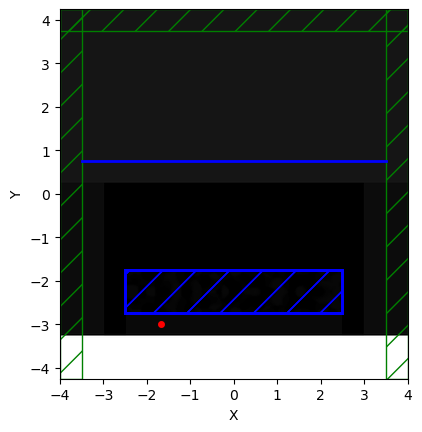

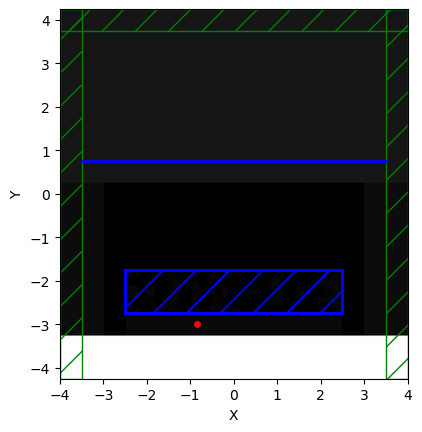

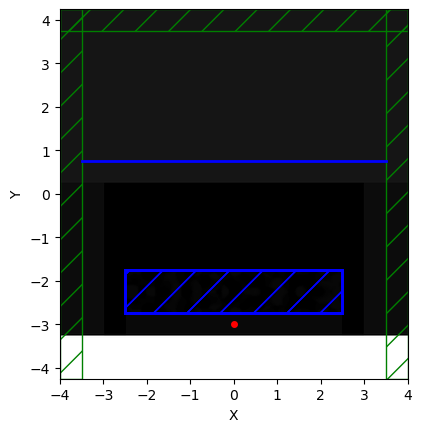

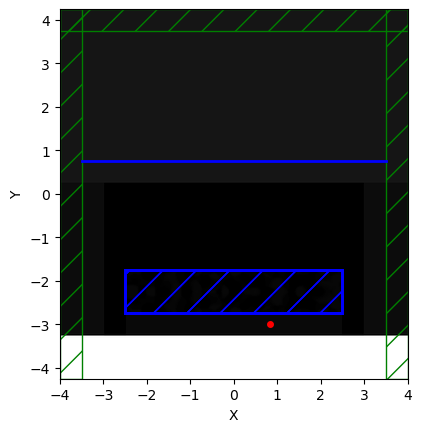

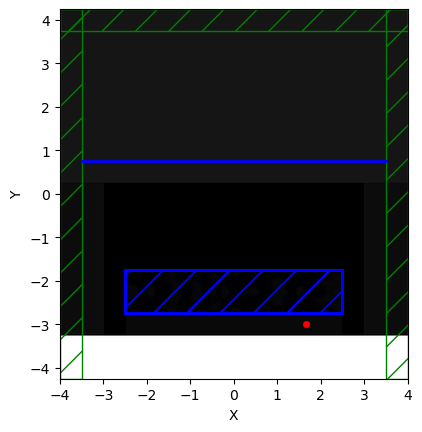

In [8]:
minimum_length = 0.09
eta_e = 0.55

filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
eta_i = 0.5
eta_d = 1 - eta_e

def mapping(x, eta, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    projected_field = (
        npa.fliplr(projected_field) + projected_field
    ) / 2  # up-down symmetry

    # interpolate to actual materials
    return projected_field.flatten()

np.random.rand(0)

plt.figure()
x0 = mapping(
    
    np.random.rand(
        Nx * Ny,
    ),
    eta_i,
    128,
)

mp.verbosity(0)
for i in range(n_dipole): 
    opt[i].update_design([x0])
    opt[i].plot2D(True)
    plt.show()

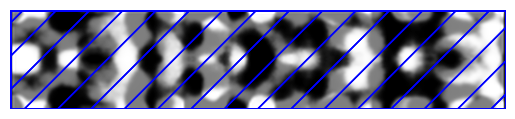

In [9]:
plt.figure()
ax = plt.gca()
opt[0].plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
# ax.add_patch(circ)
ax.axis("off")
plt.show()

In [10]:
import numpy as np

data = np.loadtxt('lastdesign.txt')

print("Loaded array shape:", data.shape)

opt[i].update_design([data])


Loaded array shape: (12801,)


# nlopt

In [12]:
evaluation_history = []
cur_iter = [0]
numevl = 0

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0 = []
    dJ_du = []

    global numevl

    for i in range(n_dipole):
        f0_i, dJ_du_i = opt[i]([mapping(v, eta_i, beta)])
        f0.append(f0_i.flatten())
        dJ_du.append(dJ_du_i)
        
        
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=0)
        )  # backprop

    evaluation_history.append([np.max(np.real(f0[i])) for i in range(n_dipole)])

    numevl += 1
    cur_iter[0] = cur_iter[0] + 1

    print("First FoM: {}".format(evaluation_history[0]))
    print("Current f0 values: " + ", ".join(["f0_{}: {}".format(i, np.real(f0[i])) for i in range(n_dipole)]))

    return np.mean(f0)  # return the sum of the objective function values


In [12]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 8
update_factor = 10
ftol = 1e-5

for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [0.822339562345118, 0.7894729056312213, 0.7854794716894778, 0.7894729056312207, 0.8223395623451185]
Current f0 values: f0_0: [0.82233956], f0_1: [0.78947291], f0_2: [0.78547947], f0_3: [0.78947291], f0_4: [0.82233956]
Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM

In [ ]:
# np.savetxt("lastdesign.txt", design_variables.weights)

In [13]:
font_label = 16

In [13]:
plt.figure()


plt.plot(np.mean(evaluation_history, axis =1), "or-")
plt.grid(True)
plt.xlabel("Iteration",  fontsize = font_label)
plt.ylabel("FOM", fontsize = font_label)
plt.xticks(fontsize = font_label)
plt.yticks(fontsize = font_label)
plt.show()


AxisError: axis 1 is out of bounds for array of dimension 1

<Figure size 640x480 with 0 Axes>

In [108]:
evaluation_history

[[0.822339562345118,
  0.7894729056312213,
  0.7854794716894778,
  0.7894729056312207,
  0.8223395623451185],
 [1.2331554068702768,
  1.4390161782203545,
  1.6043449039850042,
  1.4390161782203361,
  1.2331554068702744],
 [0.9961285363077503,
  1.18295617535585,
  1.5972910959321251,
  1.182956175355847,
  0.9961285363077421],
 [1.1420082610709537,
  1.3414836871430422,
  1.6149577546735783,
  1.3414836871430318,
  1.142008261070946],
 [1.1984828811644896,
  1.3991902932527147,
  1.6118268890291945,
  1.3991902932527005,
  1.1984828811644839],
 [1.2188811502546542,
  1.421946744284633,
  1.608283588373378,
  1.4219467442846163,
  1.2188811502546495],
 [1.226989047824046,
  1.4314650475414794,
  1.6062442861780195,
  1.4314650475414619,
  1.2269890478240422],
 [1.2304206356490581,
  1.435626139957043,
  1.6052305062643,
  1.4356261399570254,
  1.2304206356490546],
 [1.231926578653694,
  1.4374839389160736,
  1.6047520106600046,
  1.4374839389160559,
  1.2319265786536904],
 [1.2325998129

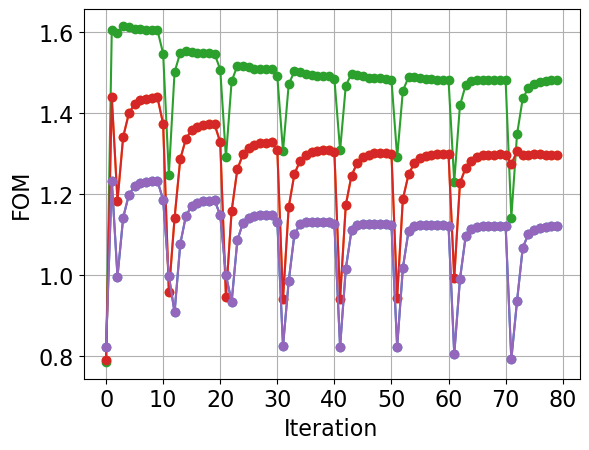

In [109]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration",  fontsize = font_label)
plt.ylabel("FOM", fontsize = font_label)
plt.xticks(fontsize = font_label)
plt.yticks(fontsize = font_label)
plt.show()

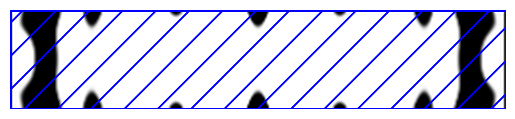

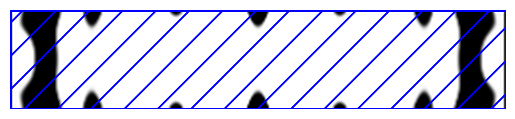

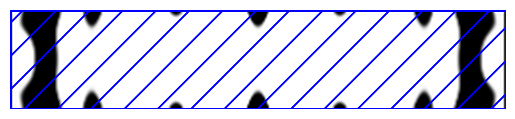

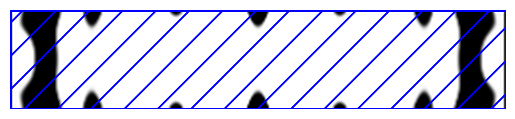

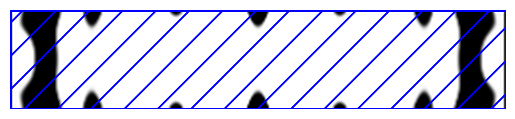

In [14]:
for i in range(n_dipole): 
    plt.figure()
    ax = plt.gca()
    opt[i].plot2D(
        True,
        output_plane = mp.Volume(size = design_region.size, center = design_region.center),
        # ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

In [39]:
opt_sim = []

sources = []
n_dipole=5

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

for i in range(n_dipole):
    # x: 디자인 영역 너비를 (i+1)/(n_dipole+1) 비율로 분할
    x_i = -design_region_width/2 + design_region_width * ((i+1) / (n_dipole+1))
    
    sources.append(
        mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                x_i,
                center_y_alq3,  # Alq3 층의 중간 높이
                0
            )
        )
    )
    opt[i].sim = mp.Simulation(
        cell_size=mp.Vector3(Sx, Sy),
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[sources[i]],
        default_material=air,
        resolution=resolution,
    )

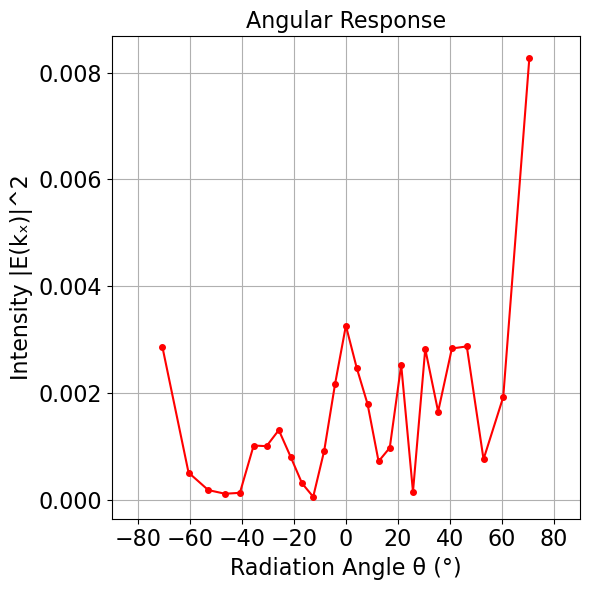

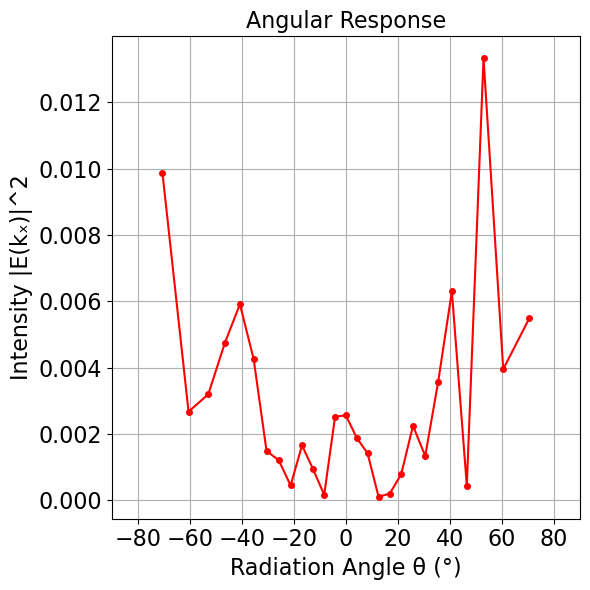

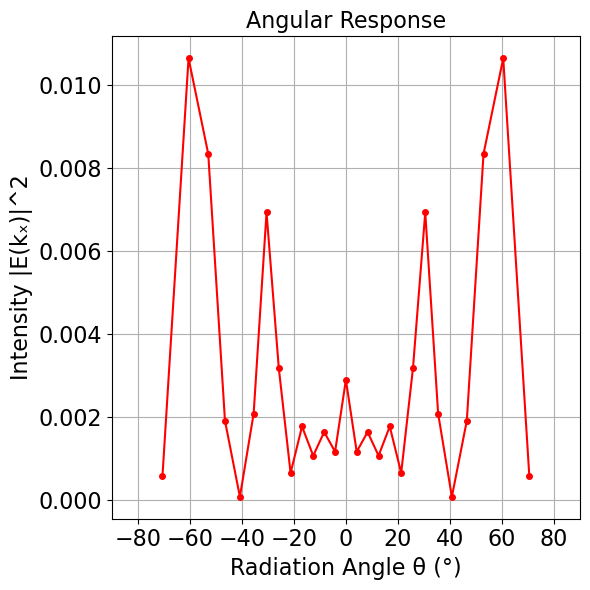

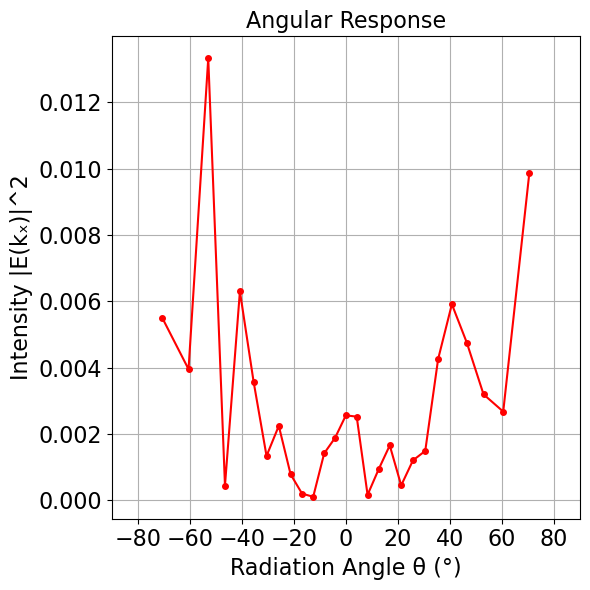

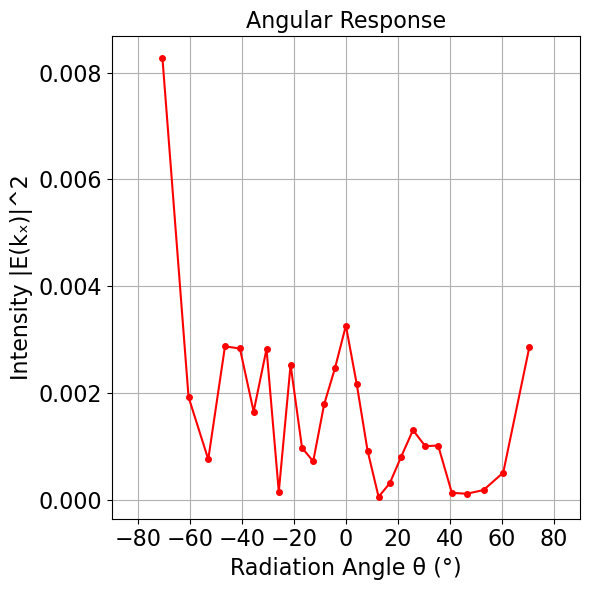

In [40]:
dft_fields_list = []

for i in range(n_dipole):
    
    dft_fields_size = tmetal_boundary+design_region_width+tmetal_boundary

    dft_fields = opt[i].sim.add_dft_fields([mp.Ez], fcen, 0, 1, 
                                    center = mp.Vector3(0, center_y_sio2+tsio2/2+1/fcen),
                                    size = mp.Vector3(dft_fields_size,0,0), 
                                    yee_grid=True)
    offset = 0.01
    flux_size = 0.02
    dft_fields_list.append(dft_fields)

    total_flux = opt[i].sim.add_flux(
    fcen, 0, 1,
    mp.FluxRegion(center=sources[i].center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X, 
                  weight=-1),
    mp.FluxRegion(center=sources[i].center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X
                  ),
    mp.FluxRegion(center=sources[i].center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=sources[i].center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
    )

    tol = 1e-3
    
    opt[i].sim.run(mp.dft_ldos(fcen,0,1), until_after_sources=mp.stop_when_fields_decayed(30, mp.Ez, sources[i].center, tol))

    dft_fields_Ez = opt[i].sim.get_dft_array(dft_fields_list[i], mp.Ez, 0)

    N = len(dft_fields_Ez)
    dx = 1.0 / resolution       # (unit length 당 샘플링 간격)
    k0 = 2 * np.pi * fcen       # (rad per unit length)

    E_k = np.fft.fftshift(np.fft.fft(dft_fields_Ez)) / N    # shape = (N,)

    # (2-2) “cycle per unit length” 단위의 x축 빈도 (shape = (N,))
    kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))

    # (2-3) rad per unit length → kx 값
    kx = 2 * np.pi * kx_cycles    # shape = (N,)

    mask = np.abs(kx) <= k0      # k0보다 작은 것들은 evanescent mode로 분류
    kx_prop = kx[mask]           # shape = (M,), M <= N

    ky_prop = np.sqrt(np.maximum(k0**2 - kx_prop**2, 0.0))   # shape = (M,)

    theta = np.arcsin(kx_prop / k0)      # radians
    theta_deg = np.degrees(theta)       # degrees

    amplitude = np.abs(E_k)              # shape = (N,)
    amplitude_prop = amplitude[mask]**2     # 전파 가능 성분만 (shape = (M,))

    font_label = 16

    plt.figure(figsize=(6, 6))
    plt.plot(theta_deg, amplitude_prop, '-ro', markersize=4)
    plt.xlabel("Radiation Angle θ (°)", fontsize=font_label)
    plt.ylabel("Intensity |E(kₓ)|^2",        fontsize=font_label)
    plt.title("Angular Response", fontsize=font_label)
    plt.xticks(fontsize = font_label)
    plt.yticks(fontsize = font_label)

    plt.grid(True)
    plt.xlim([-90, +90])   # θ ∈ [−90°, +90°] 범위
    plt.tight_layout()
    plt.show()

    plt.show()

<Axes: xlabel='X', ylabel='Y'>

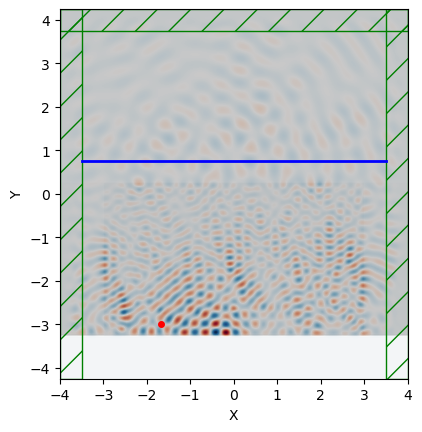

In [26]:
# opt[2].sim.run(until=1)
opt[0].sim.plot2D(fields = mp.Ez)

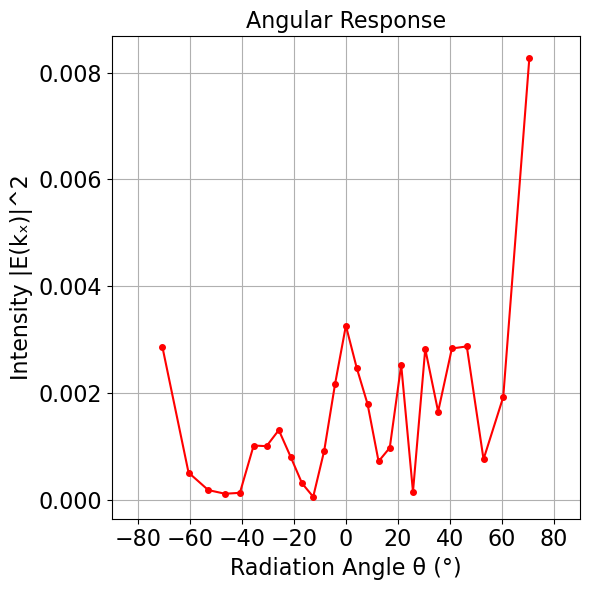

[0] input_flux :  [0.24009] 
 Out flux :  0.00164
EQE(%) :  [0.68307718]


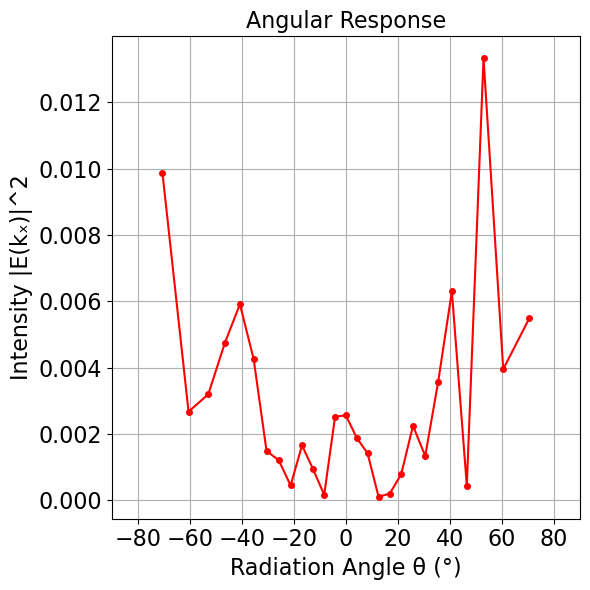

[1] input_flux :  [0.24009] 
 Out flux :  0.00307
EQE(%) :  [1.27868716]


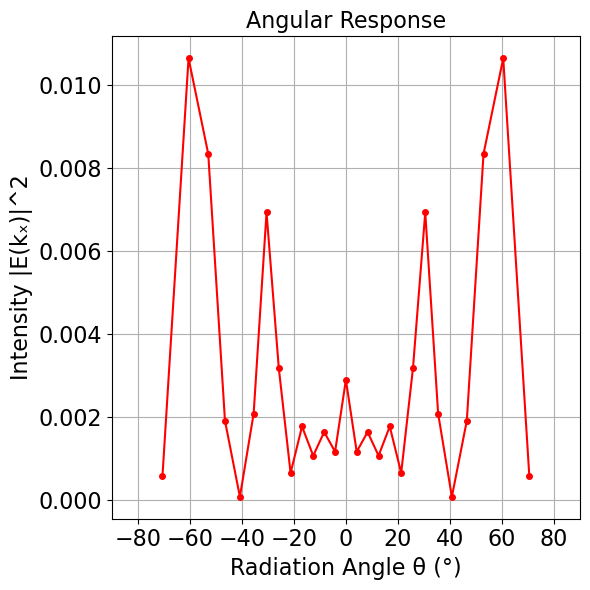

[2] input_flux :  [0.24009] 
 Out flux :  0.00307
EQE(%) :  [1.27868716]


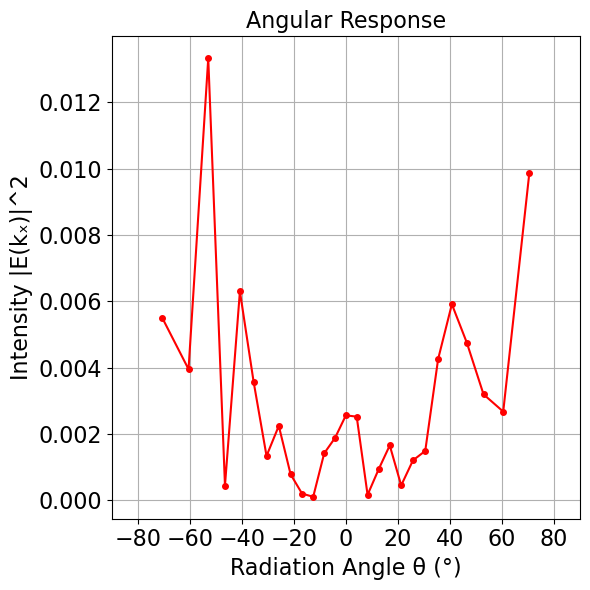

[3] input_flux :  [0.24009] 
 Out flux :  0.00307
EQE(%) :  [1.27868716]


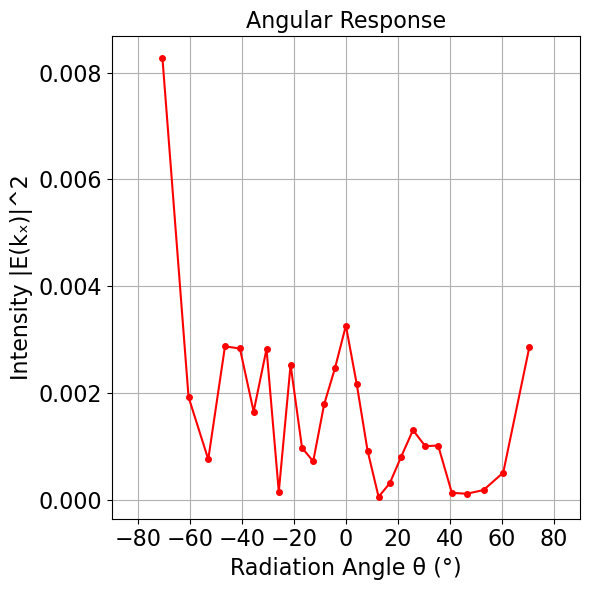

[4] input_flux :  [0.24009] 
 Out flux :  0.00164
EQE(%) :  [0.68307718]


In [60]:
for i in range(n_dipole):
    dft_fields_Ez = opt[i].sim.get_dft_array(dft_fields_list[i], mp.Ez, 0)

    N = len(dft_fields_Ez)
    dx = 1.0 / resolution       # (unit length 당 샘플링 간격)
    k0 = 2 * np.pi * fcen       # (rad per unit length)

    E_k = np.fft.fftshift(np.fft.fft(dft_fields_Ez)) / N    # shape = (N,)

    # (2-2) “cycle per unit length” 단위의 x축 빈도 (shape = (N,))
    kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))

    # (2-3) rad per unit length → kx 값
    kx = 2 * np.pi * kx_cycles    # shape = (N,)

    mask = np.abs(kx) <= k0      # k0보다 작은 것들은 evanescent mode로 분류
    kx_prop = kx[mask]           # shape = (M,), M <= N

    ky_prop = np.sqrt(np.maximum(k0**2 - kx_prop**2, 0.0))   # shape = (M,)

    theta = np.arcsin(kx_prop / k0)      # radians
    theta_deg = np.degrees(theta)       # degrees

    amplitude = np.abs(E_k)              # shape = (N,)
    amplitude_prop = amplitude[mask]**2     # 전파 가능 성분만 (shape = (M,))

    font_label = 16

    plt.figure(figsize=(6, 6))
    plt.plot(theta_deg, amplitude_prop, '-ro', markersize=4)
    plt.xlabel("Radiation Angle θ (°)", fontsize=font_label)
    plt.ylabel("Intensity |E(kₓ)|^2",        fontsize=font_label)
    plt.title("Angular Response", fontsize=font_label)
    plt.xticks(fontsize = font_label)
    plt.yticks(fontsize = font_label)

    plt.grid(True)
    plt.xlim([-90, +90])   # θ ∈ [−90°, +90°] 범위
    plt.tight_layout()
    plt.show()

    input_flux = mp.get_fluxes(total_flux)
    print([i], "input_flux : ", np.round(input_flux,5), "\n", "Out flux : ", np.round(np.mean(amplitude_prop),5))
    print("EQE(%) : ", np.round(np.mean(amplitude_prop),5) / np.round(input_flux,5) * 100)

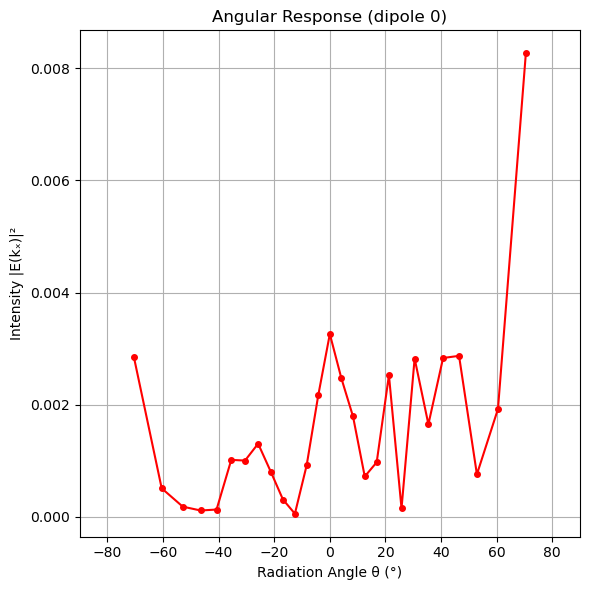

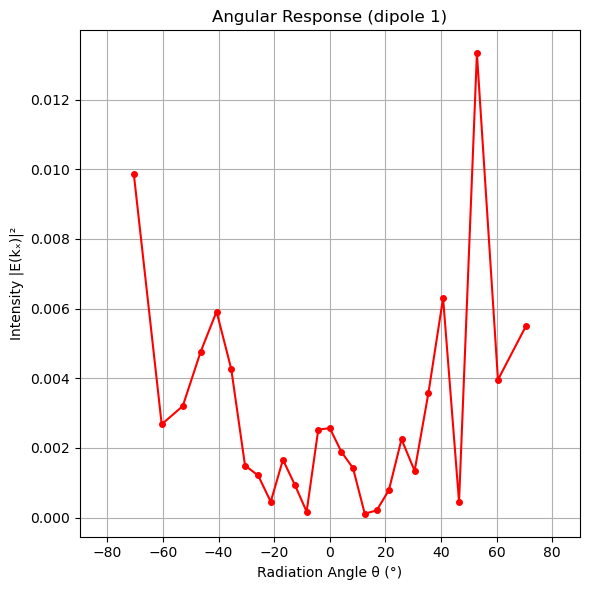

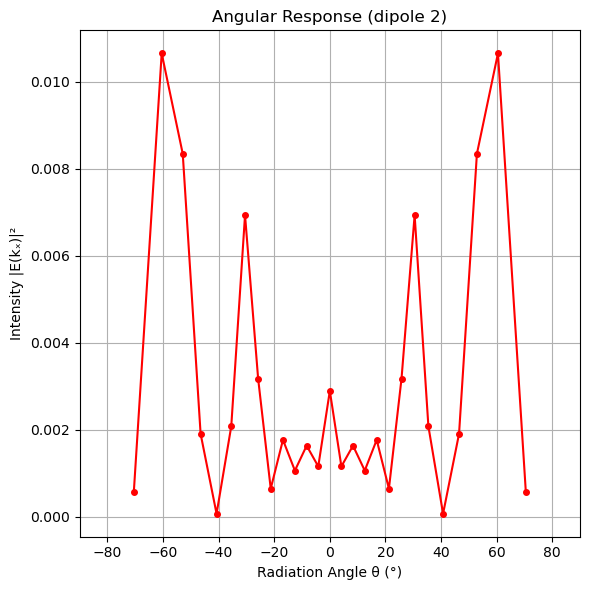

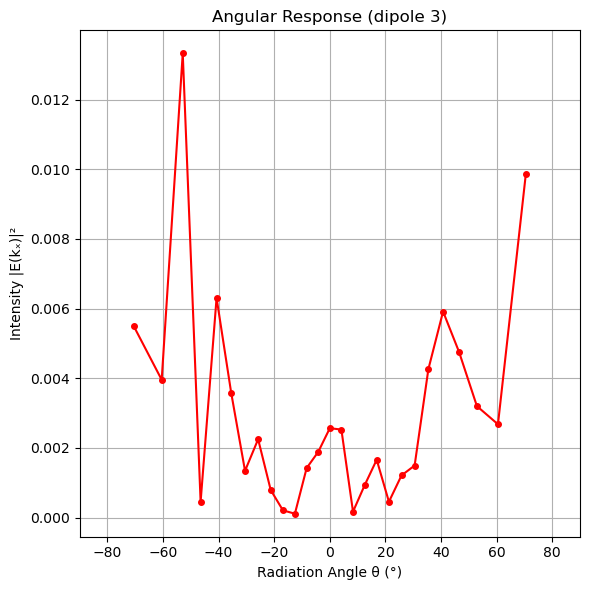

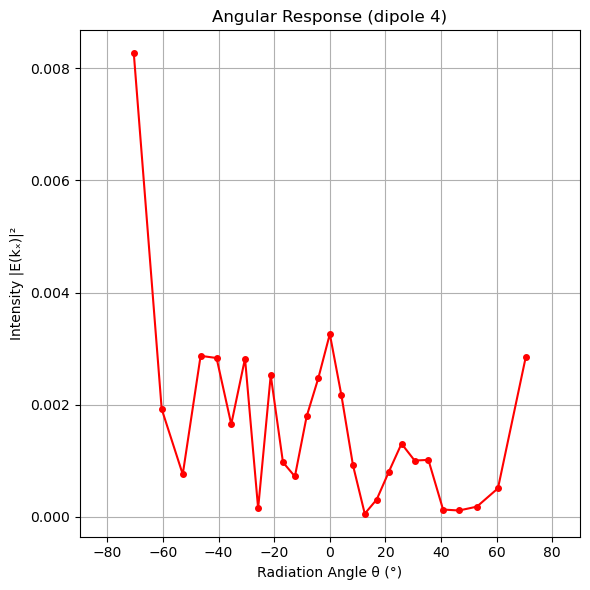

Saved angular responses to angular_responses.csv


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

all_data = []  # dipole별 angular response 저장용 리스트

for i in range(n_dipole):
    # 기존 angular response 계산
    dft_fields_Ez = opt[i].sim.get_dft_array(dft_fields_list[i], mp.Ez, 0)

    N = len(dft_fields_Ez)
    dx = 1.0 / resolution
    k0 = 2 * np.pi * fcen

    E_k = np.fft.fftshift(np.fft.fft(dft_fields_Ez)) / N
    kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))
    kx = 2 * np.pi * kx_cycles
    mask = np.abs(kx) <= k0

    theta = np.arcsin(kx[mask] / k0)
    theta_deg = np.degrees(theta)
    amplitude_prop = np.abs(E_k)[mask]**2

    # ① all_data에 기록
    for angle, intensity in zip(theta_deg, amplitude_prop):
        all_data.append({
            "dipole": i,
            "angle_deg": angle,
            "intensity": intensity
        })

    # ② 기존 플로팅
    plt.figure(figsize=(6,6))
    plt.plot(theta_deg, amplitude_prop, '-ro', markersize=4)
    plt.xlabel("Radiation Angle θ (°)")
    plt.ylabel("Intensity |E(kₓ)|²")
    plt.title(f"Angular Response (dipole {i})")
    plt.xlim(-90, 90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ③ flux 및 EQE 출력
    input_flux = mp.get_fluxes(total_flux)
    out_flux = np.mean(amplitude_prop)
    # print(f"[{i}] input_flux: {input_flux:.5f}, out_flux: {out_flux:.5f}")
    # print(f"EQE(%): {out_flux / input_flux * 100:.2f}\n")

# 반복문 종료 후: DataFrame으로 변환 후 CSV 저장
df = pd.DataFrame(all_data, columns=["dipole", "angle_deg", "intensity"])
df.to_csv("angular_responses.csv", index=False)
print("Saved angular responses to angular_responses.csv")


In [ ]:
0.00307

In [63]:
dA = 1 / (resolution**2)

for i in range(n_dipole):
    ldos_total_flux = -np.real(opt[i].sim.ldos_Fdata[0] * np.conj(opt[i].sim.ldos_Jdata[0])) *dA

In [64]:
ldos_total_flux

0.5966364296279616

In [46]:
total = mp.get_fluxes(total_flux)
total

[0.24009474174977585]

In [35]:
total = mp.get_fluxes(total_flux)

0.00205 / np.array(total) *100

array([0.79119983])

In [39]:
0.00163 / ldos_total_flux *100

0.25636262668813264

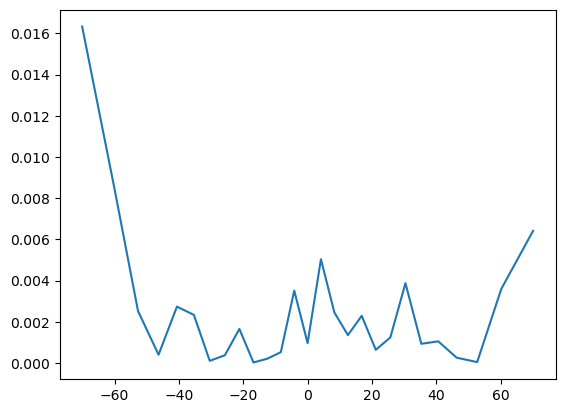

In [36]:
plt.plot(theta_deg, amplitude_prop / ldos_total_flux)